In [109]:
%matplotlib notebook
from AAE import AAE, Encoder, Decoder, Discriminator
from tools.config import Config, read_conf
from train import train
from test import test, test_show
from generator import generator
from tools.dataset import MRTDataset

import torch.nn as nn
import torch
from torch.autograd import Variable
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

[Cuda: True]


<IPython.core.display.Javascript object>


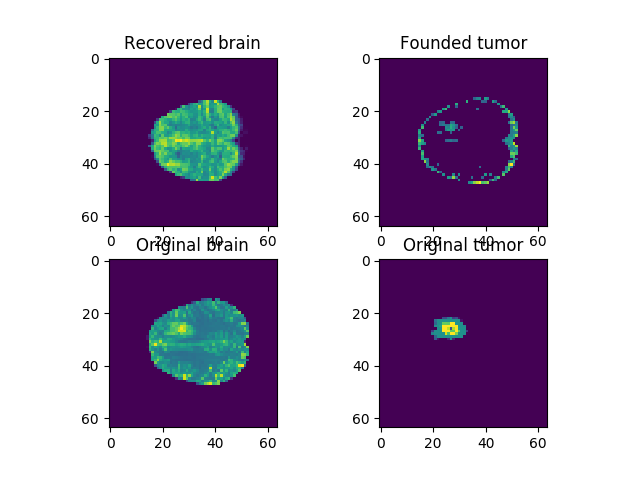

In [128]:
config = read_conf(f'/root/cAAE/config/config_test.json')
load_path = '/root/weights'
model = test_show(config, load_path, 0.2)

In [129]:
config = read_conf(f'/root/cAAE/config/config_test.json')
load_path = '/root/weights'
model = test(config, load_path, 0.2)




Testing:   0%|          | 0/5 [00:00<?, ?it/s]

[Cuda: True]
lol





Testing:  20%|██        | 1/5 [00:10<00:42, 10.55s/it]


Testing:  40%|████      | 2/5 [00:21<00:31, 10.58s/it]


Testing:  60%|██████    | 3/5 [00:31<00:21, 10.53s/it]


Testing:  80%|████████  | 4/5 [00:42<00:10, 10.55s/it]


Testing: 100%|██████████| 5/5 [00:52<00:00, 10.53s/it]

pixelwise loss on brain: 0.003602799560342516
tumor coverage: 0.028650129430269924
